In [62]:
!pip install numpy
!pip install matplotlib
!pip install ssnmf
!pip install scipy
!pip install pandas

import numpy as np
from matplotlib import pyplot as plt
import ssnmf
from ssnmf import SSNMF
import scipy
import random
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.optimize import nnls
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.optimize import nnls

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
# load b cell

# Load the CSV file into a DataFrame
# Replace 'path_to_sparse_matrix.csv' with the actual file path
data = pd.read_csv('tcell_matrix.csv')

# Assuming the CSV has columns named 'row', 'col', and 'data'
rows = data['row']
cols = data['col']
values = data['data']

# Create a sparse matrix in COO format
# The shape should match the expected dimensions of the sparse matrix
# Replace (num_rows, num_cols) with the actual size of your matrix
num_rows = rows.max() + 1 
num_cols = cols.max() + 1
bcell_matrix = coo_matrix((values, (rows, cols)), shape=(num_rows, num_cols))

# Optionally, convert to CSR or CSC format if needed
bcell_matrix = bcell_matrix.tocsr()  # CSR format
# sparse_matrix = sparse_matrix.tocsc()  # CSC format

# For labeled matrix
bcell_labeled = pd.read_csv('tcell_labeled.csv', header = None)

# get matrix into correct form
X = scipy.sparse.csr_matrix.toarray(bcell_matrix)
print(X)

# Get learning matrix, remove corresponding test col
L = np.array(bcell_labeled)
print(L)

[[3. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 0. ... 0. 0. 0.]
 [8. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1 1 1 ... 0 0 0]
 [0 0 0 ... 1 1 1]]


Fold 1
Fold 1 Accuracy: 0.6635


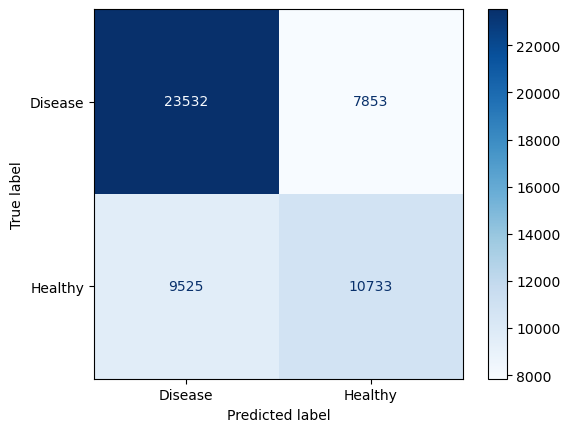

Fold 2
Fold 2 Accuracy: 0.6668


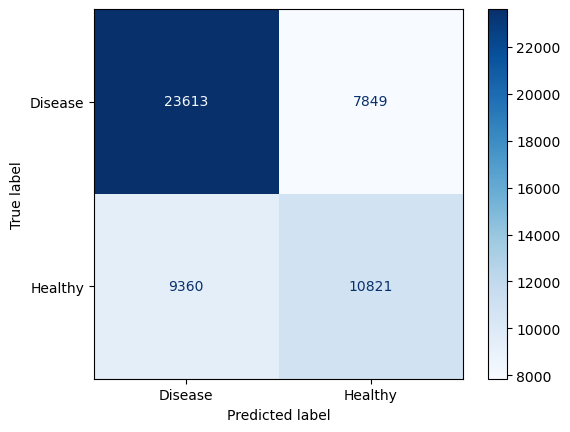

Fold 3
Fold 3 Accuracy: 0.6695


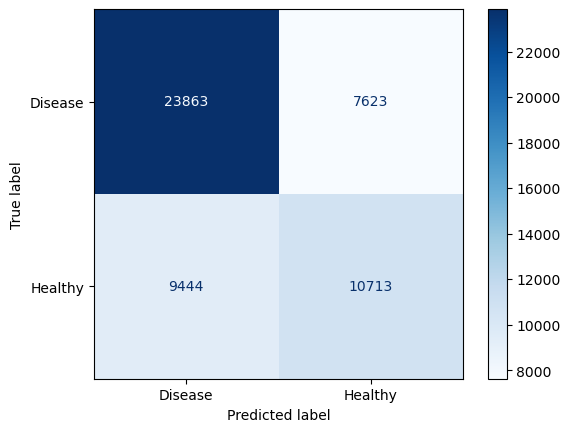

Fold 4
Fold 4 Accuracy: 0.6667


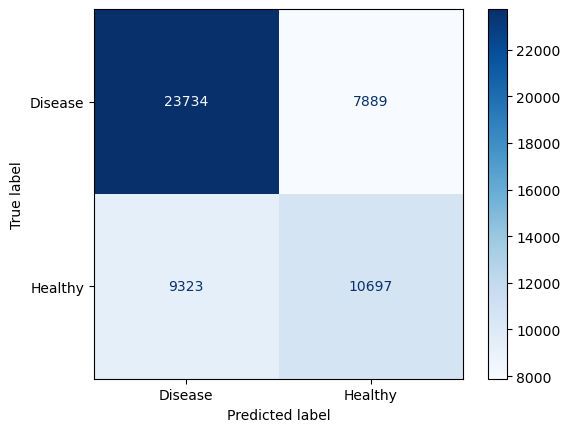

Fold 5
Fold 5 Accuracy: 0.6674


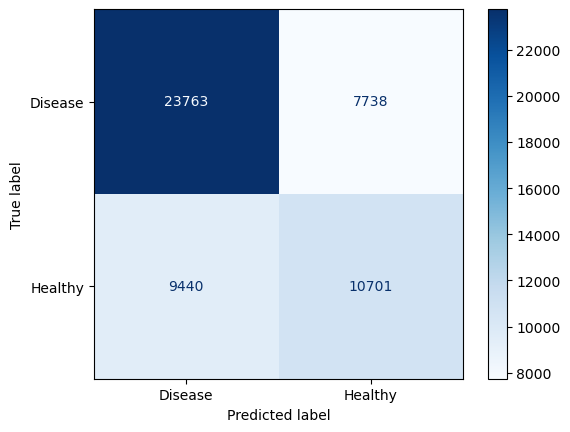


Mean Accuracy: 0.6668
Standard Deviation of Accuracy: 0.0019


In [64]:
# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder to store results
fold_accuracies = []

# Custom K-Fold Loop
for fold, (train_index, test_index) in enumerate(kf.split(np.arange(X.shape[1]))):
    print(f"Fold {fold + 1}")
    
    # Split data into training and test sets
    X_train, X_test = X[:, train_index], X[:, test_index]
    L_train, L_test = L[:, train_index], L[:, test_index]

    k = 2
    model = SSNMF(X_train, k, Y=L_train, lam=100*np.linalg.norm(X, 'fro'), modelNum=3)
    A0 = model.A
    S0 = model.S
    N = 100
    [errs, reconerrs, classerrs, classaccs] = model.mult(numiters=N, saveerrs=True)
    B = model.B
    A = model.A
    S = model.S
    
    y_test = []
    y_pred = []
    numCorrect = 0  # Initialize numCorrect for this fold
    
    # Loop over test samples
    for i in range(X_test.shape[1]):  # Ensure you're iterating over the correct dimension (columns of X_test)
        X_t = X_test[:, i]
        L_t = L_test[:, i]
        
        # Apply SSNMF model to each test sample
        s, _ = nnls(A, X_t)  # Solve the non-negative least squares problem
        y = B @ s  # Predicted output
        
        # Append true labels
        if L_t[0] == 1:
            orig = "healthy"
            y_test.append(1)
        else:
            orig = "disease"
            y_test.append(0)
        
        # Predicted class
        if y[0] > y[1]:
            pred = "healthy"
            y_pred.append(1)
        else:
            pred = 'disease'
            y_pred.append(0)
        
        # Compare prediction with true label
        if orig == pred:
            numCorrect += 1

    # Accuracy calculation for the fold
    accuracy = numCorrect / X_test.shape[1]
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    
    # Evaluate model performance using confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Disease", "Healthy"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Calculate overall performance
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nMean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


In [68]:
gene_index = pd.read_csv('genelist.csv')
gene_index.index = gene_index.index + 2
gene_index.head()

,C1orf112
2,FGR
3,CFH
4,NIPAL3
5,BAD
6,CD99


In [58]:
threshold = 3

# Find rows, cols where values are greater than the threshold
rows, cols = np.where(A > threshold)

# Print gene names for those rows
for r, c in zip(rows, cols):
    gene_name = gene_index.loc[r, 'C1orf112']  # Use the row index to get the gene name
    print(f"Value: {A[r, c]:.6f}, Row: {r}, Gene: {gene_name}, Column: {c}")
print("mean of A is", A.mean())
print("figure 6")

Value: 4.471208, Row: 96, Gene: PRDM11, Column: 0
Value: 3.286481, Row: 96, Gene: PRDM11, Column: 1
Value: 3.056630, Row: 523, Gene: WDR76, Column: 0
Value: 3.219838, Row: 523, Gene: WDR76, Column: 1
Value: 7.706994, Row: 1073, Gene: CD83, Column: 0
Value: 6.733536, Row: 1073, Gene: CD83, Column: 1
Value: 4.342328, Row: 1182, Gene: MORN1, Column: 0
Value: 3.878683, Row: 1182, Gene: MORN1, Column: 1
Value: 3.463984, Row: 1859, Gene: TLR2, Column: 0
Value: 3.093114, Row: 1859, Gene: TLR2, Column: 1
Value: 3.715929, Row: 1904, Gene: SEMA7A, Column: 0
Value: 10.185510, Row: 2121, Gene: ZC3H8, Column: 0
Value: 8.923961, Row: 2121, Gene: ZC3H8, Column: 1
Value: 7.801981, Row: 2385, Gene: CARHSP1, Column: 0
Value: 6.788574, Row: 2385, Gene: CARHSP1, Column: 1
Value: 3.114657, Row: 2478, Gene: FAM161B, Column: 0
Value: 3.616470, Row: 2794, Gene: CMYA5, Column: 0
Value: 3.817788, Row: 4726, Gene: C8orf37-AS1, Column: 0
Value: 4.615613, Row: 4726, Gene: C8orf37-AS1, Column: 1
mean of A is 0.1054

In [60]:
ratios = np.where(A[:, 1] != 0, A[:, 0] / A[:, 1], 0)

thresholdmax = 5  # Example: Consider ratios greater than 5 as having a huge difference
thresholdmin = 0.4
# Find rows where the absolute ratio difference exceeds the threshold
rows_max = np.where(np.abs(ratios) > thresholdmax)[0]  
rows_min = np.where(np.abs(ratios) < thresholdmin)[0]

# Print results
for r in rows_max:
    gene_name = gene_index.loc[r, 'C1orf112']
    print(f"Ratio: {ratios[r]:.6f}, Row: {r}, Gene: {gene_name}, Numerator: {A[r, 0]}, Denominator: {A[r, 1]}")

for r in rows_min:
    gene_name = gene_index.loc[r, 'C1orf112']
    print(f"Ratio: {ratios[r]:.6f}, Row: {r}, Gene: {gene_name}")
print("figure 7")

Ratio: 30.731564, Row: 3631, Gene: TOB2, Numerator: 0.04228669601315415, Denominator: 0.0013760020807123436
Ratio: 5.524879, Row: 4063, Gene: TEX45, Numerator: 0.005785452570242628, Denominator: 0.0010471637310023065
Ratio: 14.715007, Row: 4181, Gene: ZDHHC11B, Numerator: 0.004036331043058196, Denominator: 0.0002743003185985812
Ratio: 5.085403, Row: 4471, Gene: LINC00665, Numerator: 0.025086508614866006, Denominator: 0.00493304280644709
Ratio: 17.592066, Row: 4639, Gene: LINC02086, Numerator: 0.020937650530094536, Denominator: 0.0011901757310222832
Ratio: 38.463034, Row: 4867, Gene: A1BG-AS1, Numerator: 0.2539659987585692, Denominator: 0.006602859170332678
Ratio: 0.264866, Row: 1866, Gene: FXYD2
Ratio: 0.337574, Row: 1962, Gene: SORD
Ratio: 0.300629, Row: 2579, Gene: CBR3
Ratio: 0.375863, Row: 4018, Gene: SNHG12
Ratio: 0.377521, Row: 4418, Gene: ZRANB2-AS2
Ratio: 0.305917, Row: 4447, Gene: KLF3-AS1
Ratio: 0.237816, Row: 4460, Gene: TRAF3IP2-AS1
figure 7
